# Word-in_Context Disambiguation

## Preliminaries

First of all, let's define which approach we want to select.

Please, note that the two approaches are mutually exclusive because of design reasons.

Then, you can also select your desired configuration of hyperparameters and regularization techniques.

In [ ]:
FIRST_APPROACH = True # True or False
SECOND_APPROACH = not FIRST_APPROACH # True or False

if FIRST_APPROACH and SECOND_APPROACH:
  raise Exception('cannot execute both first and second approaches, '
   'please select only one of them')
  
if FIRST_APPROACH:
  EXTRACT_CONTEXT = True
  LEMMATIZATION = True

  N_HIDDEN = 128
  EARLY_STOPPING = False
  LEARNING_RATE = 1e-4

elif SECOND_APPROACH:
  MODEL_TYPE = 'gru'  # rnn, lstm, gru
  BIDIRECTIONAL = True
  N_HIDDEN = 128
  N_LAYERS = 2
  DROP_OUT = 0.2
  EARLY_STOPPING = False
  LEARNING_RATE = 1e-4

print('#' * 125)
print('Desired configuration:')
if FIRST_APPROACH:
  print('Approach 1: word-level')
  print('Hyperparameters: number of hidden layers =', N_HIDDEN, '| learning_rate =', LEARNING_RATE)
  if EXTRACT_CONTEXT:
    print('Applying "Context Weight Estimation"')
  if LEMMATIZATION:
    print(' + Lemmatization of the target word')
  print('Regularization: early stopping =', EARLY_STOPPING)

elif SECOND_APPROACH:
  print('Approach 2: sequence encoding')
  print('Model type:', MODEL_TYPE)
  print('Hyperparameters: bidirectional=', BIDIRECTIONAL, '| number of hidden layers =',
        N_HIDDEN, '| number of RNN layers = ', N_LAYERS, '| learning_rate =', LEARNING_RATE)
  print('Regularization: early stopping =', EARLY_STOPPING, '| dropout = ', DROP_OUT)
print('#' * 125)
  

#############################################################################################################################
Desired configuration:
Approach 1: word-level
Hyperparameters: number of hidden layers = 128 | learning_rate = 0.0001
Applying "Context Weight Estimation"
 + Lemmatization of the target word
Regularization: early stopping = False
#############################################################################################################################


In [ ]:
! pip install jsonlines

import torch
from torch.utils.data import Dataset, DataLoader
import jsonlines
import numpy as np
import re
from typing import Optional, List, Dict
import matplotlib.pyplot as plt
%matplotlib inline
from collections import defaultdict
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve, roc_auc_score

# verifying also the GPU
if not torch.cuda.is_available():
  raise Exception('please enable the GPU')

## Colab Environment setup

In [ ]:
# downloading data and restyling my directory on colab
! rm -rf sample_data
! git clone https://github.com/SapienzaNLP/nlp2021-hw1
! mkdir data
! mv nlp2021-hw1/data/train.jsonl data/.
! mv nlp2021-hw1/data/dev.jsonl data/.
! rm -rf nlp2021-hw1
! mkdir ckpt

Cloning into 'nlp2021-hw1'...
remote: Enumerating objects: 40, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 40 (delta 11), reused 18 (delta 0), pack-reused 0
Unpacking objects: 100% (40/40), done.


## Pre-trained Word Embeddings: GloVe (6B.300d)

In [ ]:
# getting pre-trained glove
! mkdir model
! wget nlp.stanford.edu/data/glove.6B.zip
! unzip -q glove.6B.zip
! mv glove.6B.300d.txt model/.
! rm -rf glove.6B.50d.txt
! rm -rf glove.6B.100d.txt
! rm -rf glove.6B.200d.txt
! rm -rf glove.6B.zip

--2021-04-30 07:17:35--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-04-30 07:17:35--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-04-30 07:17:35--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [ ]:
! head model/glove.6B.300d.txt

the 0.04656 0.21318 -0.0074364 -0.45854 -0.035639 0.23643 -0.28836 0.21521 -0.13486 -1.6413 -0.26091 0.032434 0.056621 -0.043296 -0.021672 0.22476 -0.075129 -0.067018 -0.14247 0.038825 -0.18951 0.29977 0.39305 0.17887 -0.17343 -0.21178 0.23617 -0.063681 -0.42318 -0.11661 0.093754 0.17296 -0.33073 0.49112 -0.68995 -0.092462 0.24742 -0.17991 0.097908 0.083118 0.15299 -0.27276 -0.038934 0.54453 0.53737 0.29105 -0.0073514 0.04788 -0.4076 -0.026759 0.17919 0.010977 -0.10963 -0.26395 0.07399 0.26236 -0.1508 0.34623 0.25758 0.11971 -0.037135 -0.071593 0.43898 -0.040764 0.016425 -0.4464 0.17197 0.046246 0.058639 0.041499 0.53948 0.52495 0.11361 -0.048315 -0.36385 0.18704 0.092761 -0.11129 -0.42085 0.13992 -0.39338 -0.067945 0.12188 0.16707 0.075169 -0.015529 -0.19499 0.19638 0.053194 0.2517 -0.34845 -0.10638 -0.34692 -0.19024 -0.2004 0.12154 -0.29208 0.023353 -0.11618 -0.35768 0.062304 0.35884 0.02906 0.0073005 0.0049482 -0.15048 -0.12313 0.19337 0.12173 0.44503 0.25147 0.10781 -0.17716 0.0386

As we can see, each line of the file is organized as follows:
* the first element is the word.
* the remaining N (= 300) elements encode the vector of that word.

Then, the creation of the dictionary is straightforward:

In [ ]:
word_dict = dict()

with open('model/glove.6B.300d.txt') as f:
  for line in f:
    line = line.split()
    word = line[0]
    n_values = np.asarray(line[1:], dtype='float32')
    vector = torch.tensor((n_values))
    word_dict[word] = vector

Just to test it:

In [ ]:
def cosine_similarity(v1, v2) -> float:
    num = torch.sum(v1 * v2)
    den = torch.linalg.norm(v1) * torch.linalg.norm(v2)
    return (num / den).item()

print(cosine_similarity(word_dict['mouse'], word_dict['cat']))
print(cosine_similarity(word_dict['mouse'], word_dict['click']))
print(cosine_similarity(word_dict['click'], word_dict['cat']))

0.4537908732891083
0.4263250231742859
0.11907931417226791


It will be very useful having already data stored in a list of dictionary. Therefore, let's do this operation at the beginning of our experiment.

In [ ]:
def jsonl2list(path) -> list:
  data = []
  with jsonlines.open(path) as f:
    for line in f.iter():
      data.append(line)
  return data

train_data = jsonl2list('data/train.jsonl')
dev_data = jsonl2list('data/dev.jsonl')

The final step of this first pre-processing stage is to create a list of words that are not relevant in the context of the sentences but that can add at the same time lots of not required information (at least according to my opinion).

In [ ]:
filtered = ['the', 'a', 'an',
            'on', 'in', 'at', 'since', 'for', 'ago', 'before', 'to', 'until', 'by', 'about', 'of', 'with', 'as',
            'beside', 'below', 'over', 'above', 'across', 'through', 'into', 'torwards', 'from', 'out', 'really', 'upon', 'often', 'been', 'more',
            'this', 'that', 'these', 'those', 'and', 'or', 'which', 'what', 'who', 'am', 'are', 'is', 'be', 'have', 'has', 'not',
            '', ' ', ',', '.', ';', ':', '-', 'i', 'you', 'he', 'she', 'it', 'we', 'they', 'my', 'yours', 'ours', 'its', 'his', 'him', 'her', 'their', 'them',
            'can', 'could', 'may', 'get', 'do', 'does', 'would', 'must', 'was', 'were', 'same', 'then', 'but', 'how', 'no', 'up', 'all', 'me']

## Word-in-Context Dataset Class

Another little improvement I'm proposing is the lemmatization of the target word: since we do not have guarantee that the target word appears in the pair in its 'lemma-form' (actually, it doesn't), I simply substitute its occurrences with the lemma and overcome this little issue.

The lemmatization will be used only for the first approach.

In [ ]:
class WiCDataset(Dataset):

  def __init__(
      self,
      data_list,
      pair2fn,
      device='cuda'
  ):
  
    '''
    Args:
    - data_list: list of dictionary already created that stores the dataset
    - pair2fn: function that takes as input a pair of sentences and the target
               word and that combines them according to the desired approach
    - device: "cuda" or "cpu"
    '''

    self.data = []
    self.device = device
    self.build_dataset(data_list, pair2fn)

  def build_dataset(
      self,
      data_list,
      pair2fn
  ) -> None:
    for elem in data_list:
      
      label = torch.tensor(1, dtype=torch.float32) if elem['label'] == 'True' else torch.tensor(0, dtype=torch.float32)
      
      target = elem['lemma']
      sentence1 = elem['sentence1']
      sentence2 = elem['sentence2']
      
      # apply lemmatization on the target words, if requested
      if LEMMATIZATION and FIRST_APPROACH:
        sentence1 = sentence1.replace(sentence1[int(elem['start1']):int(elem['end1'])], target)
        sentence2 = sentence2.replace(sentence2[int(elem['start2']):int(elem['end2'])], target)
        
      vectorized = pair2fn(target, sentence1, sentence2).to(self.device)
      #except:
      #  continue
      
      if vectorized is None:
        continue

      self.data.append((vectorized, label.to(self.device)))
      
  def __len__(self) -> int:
     return len(self.data)
    
  def __getitem__(self, idx: int) -> torch.Tensor:
     return self.data[idx]

## Train and Validation utilities

In [ ]:
@torch.no_grad()
def evaluate_loss(
    model: torch.nn.Module,
    dataloader: DataLoader,
):
  losses = []
  
  # switching between approaches: take into account the different input
  if FIRST_APPROACH:

    for x, y in dataloader:
        outputs = model(x, y)
        loss = outputs['loss']
        losses.append(loss)

  else:

    for x, x_length, y in dataloader:
        outputs = model(x, x_length, y)
        loss = outputs['loss']
        losses.append(loss)

  mean_loss = sum(losses) / len(losses)
  return {
      'name': 'Loss',
      'value': mean_loss,
  }

@torch.no_grad()
def evaluate_accuracy(model: torch.nn.Module,
                      dataloader: DataLoader,
                      plot: bool = False):
  correct_predictions = 0
  num_predictions = 0
  # list of ground truth and predictions to be used if 'plot' is True
  y_gt, y_pred = [], []

  # switching between approaches: take into account the different input
  if FIRST_APPROACH:
    
    for x, y in dataloader:
        outputs = model(x)
        predictions = outputs['pred']
        predictions = torch.round(predictions)
        correct_predictions += (predictions == y).sum()
        num_predictions += predictions.shape[0]

        y_gt.extend(y.tolist())
        y_pred.extend(predictions.tolist())

  else:

    for x, x_length, y in dataloader:
        outputs = model(x, x_length)
        predictions = outputs['pred']
        predictions = torch.round(predictions)
        correct_predictions += (predictions == y).sum()
        num_predictions += predictions.shape[0]

        y_gt.extend(y.tolist())
        y_pred.extend(predictions.tolist())
  
  if plot:
    # let's plot all the information about the evaluation of the model, namely:
    # - classification report
    print(classification_report(y_gt, y_pred, labels=[1, 0]))

    # - confusion matrix (as heatmap)
    cm = confusion_matrix(y_gt, y_pred, labels=[1, 0])
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt='d')

    ax.set_title('Confusion Matrix')
    ax.set_xlabel('Predicted Classes')
    ax.set_ylabel('Ground Truth Classes')
    ax.xaxis.set_ticklabels(['True', 'False'])
    ax.yaxis.set_ticklabels(['True', 'False'])
  
  accuracy = correct_predictions / num_predictions
  return{
      'name': 'Accuracy',
      'value': accuracy,
  }

In [ ]:
def train_and_evaluate(
    model: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    train_dataloader: DataLoader,
    epochs: int = 5,
    valid_dataloader: DataLoader = None,
    early_stopping: bool = False,
    early_stopping_mode: str = 'min',
    early_stopping_patience: int = 0,
    verbose: bool = True,
):

  # here we store everything about loss and accuracy of train and validation
  train_history_loss = []
  valid_history_loss = []
  train_history_acc = []
  valid_history_acc = []
  
  patience_counter = 0

  # we want only the best accuracy because it is the metric of my homework evaluation
  accuracy_max = 0

  for epoch in range(epochs):
      losses = []

      if FIRST_APPROACH:

        for x, y in train_dataloader:
            optimizer.zero_grad()
            batch_out = model(x, y)
            loss = batch_out['loss']
            losses.append(loss)

            # computes the gradient of the loss
            loss.backward()
            # updates parameters based on the gradient information
            optimizer.step()

      else:

        for x, x_length, y in train_dataloader:
            optimizer.zero_grad()
            batch_out = model(x, x_length, y)
            loss = batch_out['loss']
            losses.append(loss)

            # computes the gradient of the loss
            loss.backward()
            # updates parameters based on the gradient information
            optimizer.step()

      model.global_epoch += 1
      mean_loss = sum(losses) / len(losses)
      train_history_loss.append(mean_loss.item())
      
      valid_output = evaluate_accuracy(model, train_dataloader)
      valid_name = valid_output['name']
      valid_value = valid_output['value']
      train_history_acc.append(valid_value.item())
      
      if verbose or epoch == epochs - 1:
        print(f'  Epoch {model.global_epoch:3d} => Accuracy: {valid_value:0.6f}')
      
      if verbose and valid_dataloader:
        valid_output = evaluate_loss(model, valid_dataloader)
        valid_name = valid_output['name']
        valid_value = valid_output['value']
        valid_history_loss.append(valid_value.item())

        valid_output = evaluate_accuracy(model, valid_dataloader)
        valid_name = valid_output['name']
        valid_value = valid_output['value']
        valid_history_acc.append(valid_value.item())
        print(f'    Validation => {valid_name}: {valid_value:0.6f}')
        print()

        if early_stopping:
          stop = early_stopping_mode == 'min' and epoch > 0 and valid_history_loss[-1] > valid_history_loss[-2]
          stop = stop or early_stopping_mode == 'max' and epoch > 0 and valid_history_acc[-1] < valid_history_acc[-2]
          if stop:
            if patience_counter >= early_stopping_patience:
              print('Early stop.')
              break
            else:
              print('-- Patience.\n')
              patience_counter += 1
          

        if valid_value > accuracy_max:
          # creating checkpoint for the most performing model
          checkpoint = {
              'epoch': epoch,
              'model': model.state_dict(),
              'optimizer': optimizer.state_dict(),
          }

          # saving and updating the max accuracy reached so far
          torch.save(checkpoint, 'ckpt/best_model.pth')
          accuracy_max = valid_value

  return {
      'train_history_loss': train_history_loss,
      'valid_history_loss': valid_history_loss,
      'train_history_acc': train_history_acc,
      'valid_history_acc': valid_history_acc,
  }

## First approach: word-level

Ok, let's try something that is not so common. Since I need to perform Word-in-Context Disambiguation with uncontextualized word embeddings, I have thought about a way to 'extract' the context weight from each pair of sentences. The idea is very simple: if a target word in two sentences shares the same context, then the two most related words in these two sentences (one per sentence) may be related to each other too.

Let's see an example. I have two pairs of sentences:
* The cat eats the mouse, The mouse escaped from the predator.
* The cat eats the mouse, Use the mouse to click on the button.

where the target is 'mouse'.
The two most related words (computed with the cosine distance) with respect to the target are 'cat' and 'predator' for the first pair and 'cat' and 'click' for the second one.

Then, the cosine similarity between these words will be multiplied with the stacked vectors as a 'weight' of the context. If the target shares the same context in a pair, the weight will be higher; viceversa if it does not share the same context.

For instance, here, 'cat' and 'predator' are more related than 'cat' and 'click' (because the target, 'mouse', shares the same context in the pair).

This conclusion may not hold for each pair but it is supposed to be true for a huge number of pairs.

This very simple algorithm will be denoted with **Context Weight Estimation** (by myself : ) ).

In [ ]:
sentence1 = 'The cat eats the mouse'.lower().split()
sentence2 = 'The mouse escaped from the predator'.lower().split()
sentence3 = 'Use the mouse to click on the button'.lower().split()
target = 'mouse'

def get_context_weight(target: str, sentence1:str, sentence2: str) -> torch.Tensor:

  cos_dict1 = {}
  # computing the most related word in the first sentence
  for word in sentence1:
    if word in word_dict and word != target and word not in filtered:
      cos_dict1[word] = cosine_similarity(word_dict[target], word_dict[word])

  word1 = max(cos_dict1, key=cos_dict1.get)

  cos_dict2 = {}
  # computing the most related word in the second sentence
  for word in sentence2:
    if word in word_dict and word != target and word not in filtered:
      cos_dict2[word] = cosine_similarity(word_dict[target], word_dict[word])

  word2 = max(cos_dict2, key=cos_dict2.get)
  #print(word1, word2)
  
  # ok, now word1 and word2 are the most related words to the target
  # let's take their cosine distance
  return torch.tensor(cosine_similarity(word_dict[word1], word_dict[word2]),
                      dtype=torch.float32)

print(get_context_weight(target, sentence1, sentence2), '>', get_context_weight(target, sentence1, sentence3))

tensor(0.2104) > tensor(0.1191)


In [ ]:
def pair2vector(target:str, sentence1:str, sentence2: str):

  sentence1 = re.split('\s|(?<!\d)[",.](?!\d)', sentence1.lower())
  sentence2 = re.split('\s|(?<!\d)[",.](?!\d)', sentence2.lower())
  
  # using 'context weight' only if I want it
  context = torch.tensor(1, dtype=torch.float32)

  if EXTRACT_CONTEXT:
    if target in word_dict:
      target2vec = word_dict[target.lower()]
      context = get_context_weight(target, sentence1, sentence2)
  
  sentence12vec = [word_dict[word] for word in sentence1 if word in word_dict]
  sentence22vec = [word_dict[word] for word in sentence2 if word in word_dict]
  
  sentence12vec = torch.stack(sentence12vec)
  sentence22vec = torch.stack(sentence22vec)

  # taking the mean
  sentence12vec = torch.mean(sentence12vec, dim=0)
  sentence22vec = torch.mean(sentence22vec, dim=0)
  
  # concatenating the two vectors and trying a product with the context weight
  pair = torch.cat((sentence12vec, sentence22vec)) * context
  #print(context)
  return pair

#print(pair2vector('mouse', 'The cat eats the mouse', 'The mouse escaped from the predator'))
#print(pair2vector('mouse', 'Use the mouse to click on the button','The cat eats the mouse'))

Creating WiCDatasets and DataLoaders for the first approach:

In [ ]:
train_dataset = WiCDataset(train_data, pair2vector)
train_dataloader = DataLoader(train_dataset, batch_size=128)

dev_dataset = WiCDataset(dev_data, pair2vector)
dev_dataloader = DataLoader(dev_dataset, batch_size=128)

for batch in train_dataloader:
  X, y = batch
  print(f"batch X shape: {X.shape}")
  print(f"batch y shape: {y.shape}")
  break

batch X shape: torch.Size([128, 600])
batch y shape: torch.Size([128])


Model Class for the first approach:

In [ ]:
class WiCClassifier(torch.nn.Module):

  def __init__(
      self,
      lemmatization,
      input_features,
      hidden_size,
      output_classes
  ):
    super().__init__()
    self.lemmatization = lemmatization

    self.hidden_1 = torch.nn.Linear(input_features, hidden_size)
    self.hidden_2 = torch.nn.Linear(hidden_size, hidden_size)
    self.output_layer = torch.nn.Linear(hidden_size, output_classes)
    
    self.loss_fn = torch.nn.BCELoss()
    
    self.global_epoch = 0

  def forward(self,
              x: torch.Tensor,
              y: Optional[torch.Tensor] = None) -> dict:
    hidden_representation = self.hidden_1(x)
    hidden_representation = torch.relu(hidden_representation)
    
    hidden_representation = self.hidden_2(hidden_representation)
    hidden_representation = torch.relu(hidden_representation)
    
    out = self.output_layer(hidden_representation)
    out = out.squeeze(1)
    out = torch.sigmoid(out)
    
    result = {'pred': out}

    # compute loss
    if y is not None:
      loss = self.loss(out, y)
      result['loss'] = loss

    return result

  def loss(self, pred, y):
    return self.loss_fn(pred, y)

  def predict(self, sentence_pairs: List[Dict]) -> List[str]:
    preds = []
    
    for pair in sentence_pairs:
      target = pair['lemma']
      sentence1 = pair['sentence1']
      sentence2 = pair['sentence2']

      if self.lemmatization:
        sentence1 = sentence1.replace(sentence1[int(pair['start1']):int(pair['end1'])], target)
        sentence2 = sentence2.replace(sentence2[int(pair['start2']):int(pair['end2'])], target)

      X = pair2vector(target, sentence1, sentence2)
      X = X.unsqueeze(0)
      batch_out = self(X)
      pred = batch_out['pred']
    
      for elem in pred:
        preds.append('True' if elem > 0.5 else 'False')
    
    return preds


  Epoch   1 => Accuracy: 0.582375
    Validation => Accuracy: 0.609000

  Epoch   2 => Accuracy: 0.556375
    Validation => Accuracy: 0.583000

  Epoch   3 => Accuracy: 0.563750
    Validation => Accuracy: 0.586000

  Epoch   4 => Accuracy: 0.569750
    Validation => Accuracy: 0.597000

  Epoch   5 => Accuracy: 0.579875
    Validation => Accuracy: 0.607000

  Epoch   6 => Accuracy: 0.582625
    Validation => Accuracy: 0.608000

  Epoch   7 => Accuracy: 0.587875
    Validation => Accuracy: 0.609000

  Epoch   8 => Accuracy: 0.589500
    Validation => Accuracy: 0.612000

  Epoch   9 => Accuracy: 0.592000
    Validation => Accuracy: 0.616000

  Epoch  10 => Accuracy: 0.592375
    Validation => Accuracy: 0.622000

  Epoch  11 => Accuracy: 0.592125
    Validation => Accuracy: 0.620000

  Epoch  12 => Accuracy: 0.593000
    Validation => Accuracy: 0.618000

  Epoch  13 => Accuracy: 0.596000
    Validation => Accuracy: 0.614000

  Epoch  14 => Accuracy: 0.598125
    Validation => Accuracy: 0.

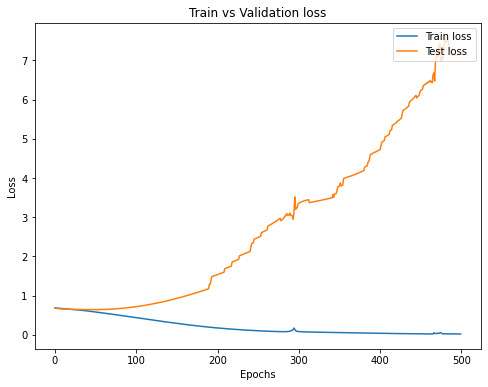

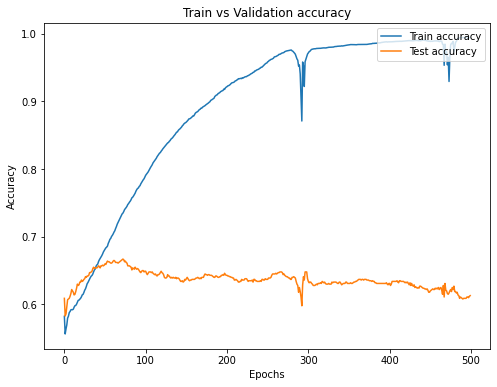

In [ ]:
if FIRST_APPROACH:
    
  model = WiCClassifier(
      lemmatization=LEMMATIZATION,
      input_features=600,
      hidden_size=N_HIDDEN,
      output_classes=1).cuda()

  optimizer = torch.optim.Adam(
      model.parameters(),
      lr=LEARNING_RATE)


  logs = train_and_evaluate(
      model=model,
      optimizer=optimizer,
      train_dataloader=train_dataloader,
      valid_dataloader=dev_dataloader,
      early_stopping=EARLY_STOPPING,
      early_stopping_mode='max',
      early_stopping_patience=20,
      epochs=500)

  plt.figure(figsize=(8,6))

  plt.plot(list(range(len(logs['train_history_loss']))), logs['train_history_loss'], label='Train loss')
  plt.plot(list(range(len(logs['valid_history_loss']))), logs['valid_history_loss'], label='Test loss')

  plt.title('Train vs Validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend(loc="upper right")

  plt.show()

  plt.figure(figsize=(8,6))

  plt.plot(list(range(len(logs['train_history_acc']))), logs['train_history_acc'], label='Train accuracy')
  plt.plot(list(range(len(logs['valid_history_acc']))), logs['valid_history_acc'], label='Test accuracy')

  plt.title('Train vs Validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(loc="upper right")

  plt.show()

model checkpoint loaded
              precision    recall  f1-score   support

           1       0.69      0.63      0.66       500
           0       0.66      0.72      0.69       500

    accuracy                           0.68      1000
   macro avg       0.68      0.68      0.68      1000
weighted avg       0.68      0.68      0.68      1000

{'name': 'Accuracy', 'value': tensor(0.6770, device='cuda:0')}


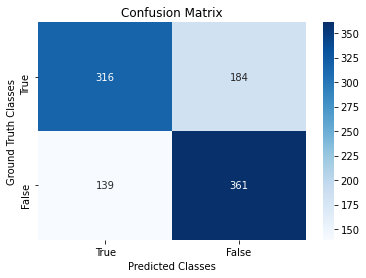

In [ ]:
if FIRST_APPROACH:

  model = WiCClassifier(
      lemmatization=LEMMATIZATION,
      input_features=600,
      hidden_size=N_HIDDEN,
      output_classes=1).cuda()
  model.load_state_dict(torch.load('ckpt/best_model.pth')['model'])
  print('model checkpoint loaded')
  acc = evaluate_accuracy(model, dev_dataloader, plot=True)
  print(acc)

## Second approach: sequence encoding

For this other approach, I have used the standard way to preprocess data. Since I have Glove embeddings, I can use them to create the dictionary of indices corresponding to words that will be 'mapped' to their vector representations.

I'm taking into account the fact that I have pair of sentences: let's introduce a specific index that will be used as a 'separator' between two sequences of indices.

In [ ]:
word_index = dict()
vectors_store = []

# pad token, index = 0
vectors_store.append(torch.rand(300))

# unk token, index = 1
vectors_store.append(torch.rand(300))

# sep token, namely <sentence1><sep><sentence2>, index = 2
vectors_store.append(torch.rand(300))

for word, vector in word_dict.items():
  word_index[word] = len(vectors_store)
  vectors_store.append(vector)

word_index = defaultdict(lambda: 1, word_index)  # default dict returns 1 (unk token) when unknown word
vectors_store = torch.stack(vectors_store)

In [ ]:
vocabulary_size, hidden_features = vectors_store.shape
print(f"Vocabulary size: {vocabulary_size}")
print(f"Hidden features: {hidden_features}")

Vocabulary size: 400003
Hidden features: 300


In [ ]:
def pair2indices(target:str, sentence1:str, sentence2: str) -> torch.Tensor:

  sentence1 = re.split('\s|(?<!\d)[",.:;](?!\d)', sentence1.lower())
  sentence2 = re.split('\s|(?<!\d)[",.:;](?!\d)', sentence2.lower())
  
  sentence12indices = [word_index[word] for word in sentence1 if word not in filtered]
  sentence22indices = [word_index[word] for word in sentence2 if word not in filtered]
  # manually appending separator index (= 2) at the end of the first 'indexed' sentence
  sentence12indices.append(2)

  sentence12indices = torch.tensor(sentence12indices, dtype=torch.long)
  sentence22indices = torch.tensor(sentence22indices, dtype=torch.long)
  
  return torch.cat((sentence12indices, sentence22indices)).cuda()

print(pair2indices('mouse', 'The cat eats the mouse', 'The mouse escaped from the predator'))
print(pair2indices('mouse', 'Use the mouse to click on the button','The cat eats the mouse'))

tensor([ 5453, 16791,  7574,     2,  7574,  4331, 15775], device='cuda:0')
tensor([  237,  7574,  9644,  6913,     2,  5453, 16791,  7574],
       device='cuda:0')


I can see the '2' between the indexed sentences above.

Now, I proceed with the creation of the Datasets and the DataLoaders, as usual.

In [ ]:
# traditional collate function to pad my batches
def collate_fn(
    data
):
  X = [d[0] for d in data]
  y = [d[1] for d in data]
  
  X_lengths = torch.tensor([x.size(0) for x in X], dtype=torch.long)
  
  X = torch.nn.utils.rnn.pad_sequence(X, batch_first=True, padding_value=0).cuda()
  
  return X, X_lengths, torch.tensor(y).cuda()

# creating new datasets with the pair2indice function now ...
train_dataset = WiCDataset(train_data, pair2fn=pair2indices)
dev_dataset = WiCDataset(dev_data, pair2fn=pair2indices)

# .. and the correspondent DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=32, collate_fn=collate_fn)
dev_dataloader = DataLoader(dev_dataset, batch_size=32, collate_fn=collate_fn)

for batch in train_dataloader:
  X, X_lengths, y = batch
  print(X)
  print(y)
  print(f"batch X shape: {X.shape}")
  print(f"batch y shape: {y.shape}")
  break

tensor([[ 4713,  6412,  4987,  ...,     0,     0,     0],
        [ 4713,  6412,  4987,  ...,     0,     0,     0],
        [   55,   120, 11194,  ...,     0,     0,     0],
        ...,
        [  113,  2496,   339,  ...,  2496,   476,   976],
        [ 3560,   216,  2917,  ...,     0,     0,     0],
        [ 3560,   216,  2917,  ...,     0,     0,     0]], device='cuda:0')
tensor([0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 1., 1.,
        0., 0., 0., 0., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1.],
       device='cuda:0')
batch X shape: torch.Size([32, 54])
batch y shape: torch.Size([32])


Model Class for the second approach:

In [ ]:
class WiCRecurrentClassifier(torch.nn.Module):
  
  def __init__(
      self,
      vectors_store: torch.Tensor,
      model_type: str,
      n_hidden: int,
      n_layers: int,
      bidirectional: bool,
      drop_out: float,
      output_classes: int
  ):

    '''
    Args:
    - vectors_store: tensor of vector embeddings created from GloVe
    - model_type: string to specify the type of recurrent architecture among "rnn", "lstm" and "gru"
    - n_hidden: number of hidden units in the linear layer
    - n_layers: number of layers in the recurrent architecture
    - bidirectional: flag to enable data flow in both directions
    - drop_out: to regulate the dropout regalurization technique
    - output_classes: binary classification -> 1
    '''

    super().__init__()
    self.n_hidden = n_hidden
    self.n_layers = n_layers
    self.bidirectional = bidirectional

    # directly initializing the embedding layer with the pretrained
    self.embedding = torch.nn.Embedding.from_pretrained(vectors_store)

    if model_type == 'lstm':
      self.rnn = torch.nn.LSTM(input_size=vectors_store.size(1),
                               hidden_size=n_hidden,
                               num_layers=n_layers,
                               batch_first=True,
                               bidirectional=bidirectional)

    elif model_type == 'gru':
      self.rnn = torch.nn.GRU(input_size=vectors_store.size(1),
                              hidden_size=n_hidden,
                              num_layers=n_layers,
                              batch_first=True,
                              bidirectional=bidirectional)

    else:
      self.rnn = torch.nn.RNN(input_size=vectors_store.size(1),
                              hidden_size=n_hidden,
                              num_layers=n_layers,
                              batch_first=True,
                              bidirectional=bidirectional)
    
    self.drop_out = torch.nn.Dropout(p=drop_out)

    # if bidirectional, take care of the input dimension of the hidden layer
    n_hidden_input = 2 * n_hidden if BIDIRECTIONAL else n_hidden

    self.hidden_layer = torch.nn.Linear(n_hidden_input, n_hidden)
    self.output_layer = torch.nn.Linear(n_hidden, output_classes)

    self.loss_fn = torch.nn.BCELoss()

    self.global_epoch = 0

  def forward(
      self,
      X: torch.Tensor,
      X_lengths,
      y:Optional[torch.Tensor] = None
  ):
    batch_size, sequence_length = X.size()
    # starting from X -> (batch_size x sequence_length)
    
    embedding_out = self.embedding(X)
    # embedding_out -> (batch_size x sequence_length x features)

    # applying dropout
    embedding_out = self.drop_out(embedding_out)

    # packing padded sequences
    packed_embedding_out = torch.nn.utils.rnn.pack_padded_sequence(embedding_out,
                                                                  X_lengths,
                                                                  batch_first=True,
                                                                  enforce_sorted=False)
    recurrent_out = self.rnn(packed_embedding_out)[0]


    # padding packed sequences
    padded_recurrent_out = torch.nn.utils.rnn.pad_packed_sequence(recurrent_out,
                                                                    batch_first=True)[0]  
    #padded_recurrent_out -> (batch_size x sequence_length x n_hidden_input)

    # if bi-LSTM, I have two directions: forward and backward ...
    # handle forward direction
    flattened_out_forward = padded_recurrent_out[range(len(padded_recurrent_out)),
                                        X_lengths - 1, :self.n_hidden]
    # flattened_out_forward -> (batch_size x n_hidden)
    
    if self.bidirectional:
      # ... therefore I need to handle also the backward direction ...
      # handle backward direction
      flattened_out_backward = padded_recurrent_out[:, 0, self.n_hidden:]
      # flattened_out_backward -> (batch_size x n_hidden)
      
      summary_vectors = torch.cat((flattened_out_forward, flattened_out_backward), 1)
      # summary_vectors -> (batch_size x 2 * n_hidden)
      # ok, now sizes should be good for the bi-LSTM

    else:
      # ... while if unidirectional, the output is straightforward
      summary_vectors = flattened_out_forward
  
      
    #summary_vectors = self.drop_out(summary_vectors)
    
    hidden_representation = self.hidden_layer(summary_vectors)
    hidden_representation = torch.relu(hidden_representation)
    out = self.output_layer(hidden_representation)
    out = out.squeeze(1)
    out = torch.sigmoid(out)
      
    result = {'pred': out}

    # compute loss
    if y is not None:
      loss = self.loss(out, y)
      result['loss'] = loss

    return result

  def loss(self, pred, y):
    return self.loss_fn(pred, y)

  def predict(self, sentence_pairs: List[Dict]) -> List[str]:
    preds = []

    for pair in sentence_pairs:
      X = pair2indices(pair['lemma'], pair['sentence1'], pair['sentence2'])
      X_length = torch.tensor([X.size(0)], dtype=torch.long)

      # add a fictitious batch_size of 1 so that the forward step works
      X = X.unsqueeze(0)
      
      batch_out = self(X, X_length)
      
      pred = batch_out['pred']
      pred = torch.round(pred)
      
      preds.append('True' if pred > 0.5 else 'False')
    
    return preds

  Epoch   1 => Accuracy: 0.554500
    Validation => Accuracy: 0.539000

  Epoch   2 => Accuracy: 0.562875
    Validation => Accuracy: 0.530000

  Epoch   3 => Accuracy: 0.574500
    Validation => Accuracy: 0.538000

  Epoch   4 => Accuracy: 0.597500
    Validation => Accuracy: 0.557000

  Epoch   5 => Accuracy: 0.624875
    Validation => Accuracy: 0.599000

  Epoch   6 => Accuracy: 0.638250
    Validation => Accuracy: 0.601000

  Epoch   7 => Accuracy: 0.663250
    Validation => Accuracy: 0.610000

  Epoch   8 => Accuracy: 0.682625
    Validation => Accuracy: 0.615000

  Epoch   9 => Accuracy: 0.695750
    Validation => Accuracy: 0.608000

  Epoch  10 => Accuracy: 0.711750
    Validation => Accuracy: 0.639000



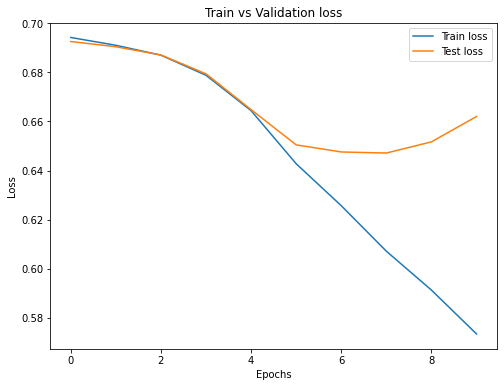

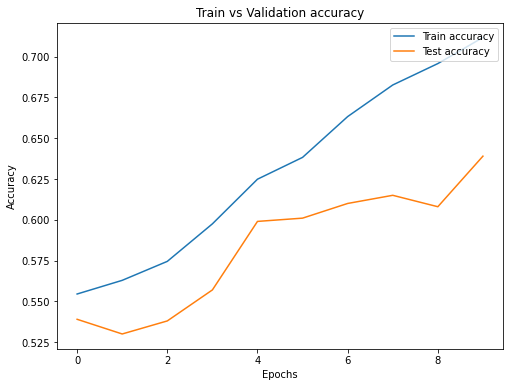

In [ ]:
if SECOND_APPROACH:
  rnnModel = WiCRecurrentClassifier(vectors_store,
                                    model_type=MODEL_TYPE,
                                    n_hidden=N_HIDDEN,
                                    n_layers=N_LAYERS,
                                    bidirectional=BIDIRECTIONAL,
                                    drop_out=DROP_OUT,
                                    output_classes=1).cuda()

  optimizer = torch.optim.Adam(
      rnnModel.parameters(),
      lr=LEARNING_RATE)

  logs = train_and_evaluate(
      model=rnnModel,
      optimizer=optimizer,
      train_dataloader=train_dataloader,
      valid_dataloader=dev_dataloader,
      early_stopping=EARLY_STOPPING,
      early_stopping_mode='max',
      early_stopping_patience=5,
      epochs=10)

  plt.figure(figsize=(8,6))

  plt.plot(list(range(len(logs['train_history_loss']))), logs['train_history_loss'], label='Train loss')
  plt.plot(list(range(len(logs['valid_history_loss']))), logs['valid_history_loss'], label='Test loss')

  plt.title('Train vs Validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend(loc="upper right")

  plt.show()

  plt.figure(figsize=(8,6))

  plt.plot(list(range(len(logs['train_history_acc']))), logs['train_history_acc'], label='Train accuracy')
  plt.plot(list(range(len(logs['valid_history_acc']))), logs['valid_history_acc'], label='Test accuracy')

  plt.title('Train vs Validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(loc="upper right")

  plt.show()

model checkpoint loaded
              precision    recall  f1-score   support

           1       0.61      0.70      0.65       500
           0       0.65      0.55      0.60       500

    accuracy                           0.63      1000
   macro avg       0.63      0.63      0.62      1000
weighted avg       0.63      0.63      0.62      1000

{'name': 'Accuracy', 'value': tensor(0.6270, device='cuda:0')}


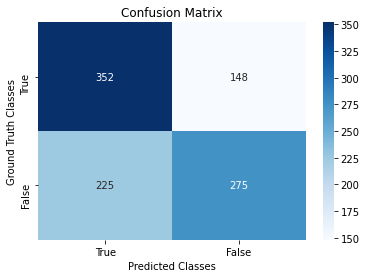

In [ ]:
if SECOND_APPROACH:
  
  model = WiCRecurrentClassifier(vectors_store,
                                 model_type=MODEL_TYPE,
                                 n_hidden=N_HIDDEN,
                                 n_layers=N_LAYERS,
                                 bidirectional=BIDIRECTIONAL,
                                 drop_out=DROP_OUT,
                                 output_classes=1).cuda()
  model.eval()
  model.load_state_dict(torch.load('ckpt/best_model.pth')['model'])
  print('model checkpoint loaded')
  acc = evaluate_accuracy(model, dev_dataloader, plot=True)
  print(acc)

## Comparing best models of the two approaches: ROC curve and AUC score

With binary classifiers (and not only) a good practise is to compute and visualize the ROC (Receiver Operating Characteristic) curve. Related to this, we have the AUC (Area Under the Curve) score that tells us how precise and sensible is the model for this task. In particular:
* AUC = 0.5, worst classifier (like predicting always False).
* AUC = 1.0, ideal classifier with no errors.

Let's see where the two most performing models of the two approaches are located between these thresholds in the plane and compute their AUC score, that is reasonably equal to their accuracies.

AUC for the best model of the FIRST approach: 0.677
AUC for the best model of the SECOND approach: 0.627


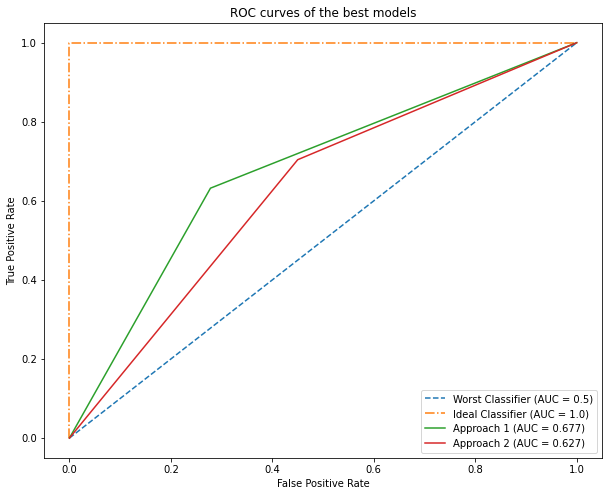

In [ ]:
model = WiCClassifier(lemmatization=LEMMATIZATION,
                      input_features=600,
                      hidden_size=N_HIDDEN,
                      output_classes=1)
model.load_state_dict(torch.load('weights_lemm.pth')['model'])

rnn_model = WiCRecurrentClassifier(vectors_store,
                                   model_type=MODEL_TYPE,
                                   n_hidden=N_HIDDEN,
                                   n_layers=N_LAYERS,
                                   bidirectional=BIDIRECTIONAL,
                                   drop_out=0.0,
                                   output_classes=1).cuda()
rnn_model.load_state_dict(torch.load('rnn_weights.pth')['model'])

# ground truth labels
y_true = []
for elem in dev_data:
  y_true.append(1 if elem['label']=='True' else 0)

# predicted labels of my two models
y_pred1 = []
predictions1 = model.predict(dev_data)
for elem in predictions1:
  y_pred1.append(1 if elem=='True' else 0)

y_pred2 = []
predictions2 = rnn_model.predict(dev_data)
for elem in predictions2:
  y_pred2.append(1 if elem=='True' else 0)

# ROC and AUC scores
fpr1, tpr1, _ = roc_curve(y_true, y_pred1)
auc1 = roc_auc_score(y_true, y_pred1)
print('AUC for the best model of the FIRST approach: %.3f' % auc1)

fpr2, tpr2, _ = roc_curve(y_true, y_pred2)
auc2 = roc_auc_score(y_true, y_pred2)
print('AUC for the best model of the SECOND approach: %.3f' % auc2)

fpr_max, tpr_max, _ = roc_curve(y_true, y_true)
fpr_min, tpr_min, _ = roc_curve(y_true, [0 for _ in dev_data])

# finally, let's plot them wrt ideal and worst classifiers
plt.figure(figsize=(10, 8))
plt.plot(fpr_min, tpr_min, linestyle='--', label='Worst Classifier (AUC = 0.5)')
plt.plot(fpr_max, tpr_max, linestyle='-.', label='Ideal Classifier (AUC = 1.0)')
plt.plot(fpr1, tpr1, label='Approach 1 (AUC = %.3f)' % auc1)
plt.plot(fpr2, tpr2, label='Approach 2 (AUC = %.3f)' % auc2)

plt.title('ROC curves of the best models')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.legend()

plt.show()